# Factor analysis of nonverbal behavior



In [ ]:
req <- readLines("requirements.txt")
proj_version <- "R version 3.6.1 (2019-07-05)"
p<-.libPaths()
`%notin%` <- Negate(`%in%`)
if (proj_version != version$version.string){
  print(paste("You have ", version$version.string, ". This project was created with R version 3.6.1 (2019-07-05). Some packages may not install or work properly"))
} else {
  print("You have the same version of R as was used in this project")
}

In [ ]:
for (i in 1:length(req)){
  pkg<-req[[i]]
  if (pkg %notin% rownames(installed.packages())){
    install.packages(pkg, p)
  }
  if (pkg %in% rownames(installed.packages()) & pkg %notin% loadedNamespaces()){
    library(pkg, character.only = T)
    print(paste("Attaching package:", pkg))
  }
  if (pkg %notin% rownames(installed.packages())){
    print(paste("Error installing ", pkg, ". Check Warnings."))
  }
}

In [14]:
messy_data<-read.delim("NIS_data/data.csv", na.strings = c("", "NA"))

In [15]:
NIS_clean<-messy_data[1:5000, ]%>% #take just the first 5,000 observations of this massive dataset
  select(c("Q1", "Q2", "Q3","Q4", "Q5", "Q6", "Q7",  "Q8",  "Q9",  "Q10", "Q11", "Q12", "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", "Q19", "Q20", "Q21", "Q22", "Q23", "Q24", "Q25", "Q26", "VCL1", "VCL2", "VCL3", "VCL4", "VCL5", "VCL6", "VCL7", "VCL8", "VCL9",  "VCL10",  "VCL11", "VCL12",  "VCL13", "VCL14", "VCL15",  "VCL16"))%>% #select the actual columns, as well as the word recognition columns 
  filter_at(vars(c("VCL6", "VCL9","VCL12")), all_vars(.==0))%>% #these three variables are not real words. This keeps only observations where only all three were marked as unknown.
  filter_at(vars(starts_with("Q")), all_vars(.!=0))%>% #0 is not a valid option in the 1-5 likert scale for NIS items. This keeps only observations where none of the Qs were answered with 0.
  select(starts_with("Q"))%>% #retains only the NIS questions
  mutate_all(as.numeric)

Test,HZ,p value,MVN
Henze-Zirkler,104,0,NO


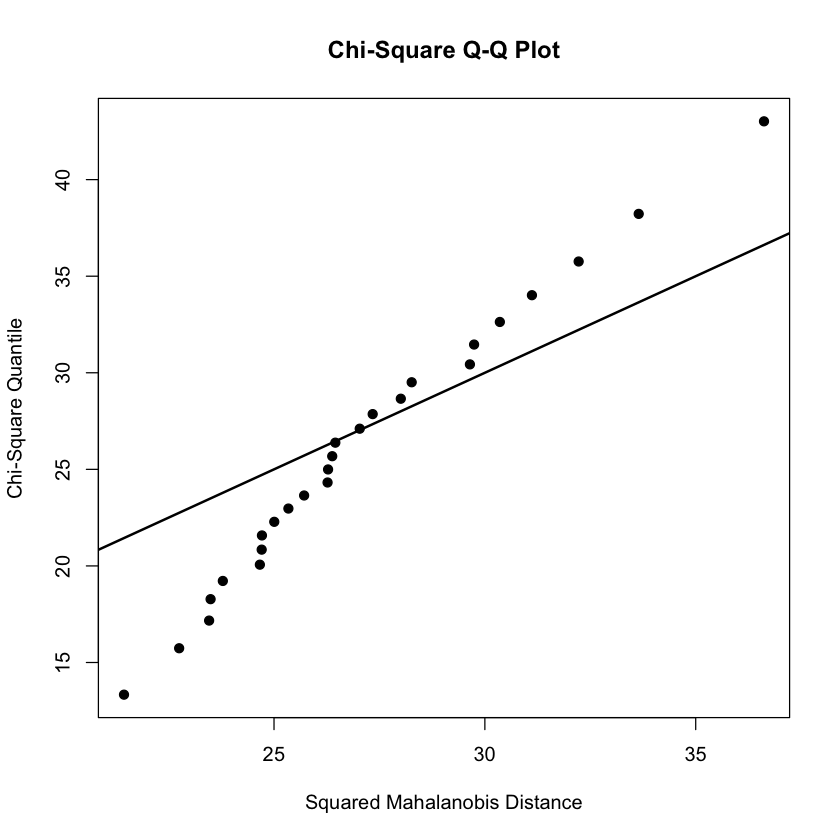

In [17]:
mvn(NIS_clean[1:length(NIS_clean), ], mvnTest = "hz", multivariatePlot = "qq")$multivariateNormality #takes only 5,000 obs

### Running the factor analysis
The polychoric correlation matrix is an estimates the theorized correlations between pairs of ordinal variables. This matrix will be used in place of a correlation matrix in the factor analysis. 

In [18]:
NIS_m<-data.matrix(NIS_clean) #save data as matrix
pcor<-polycor::hetcor(NIS_m, ML = T)$correlations #extract the polychoric correlation matrix

To determine how many factors to extract, parallel analysis compares the scree polt of successive eigenvalues of the observed data to a random matrix of the same size. 

Parallel analysis suggests that the number of factors =  8  and the number of components =  NA 


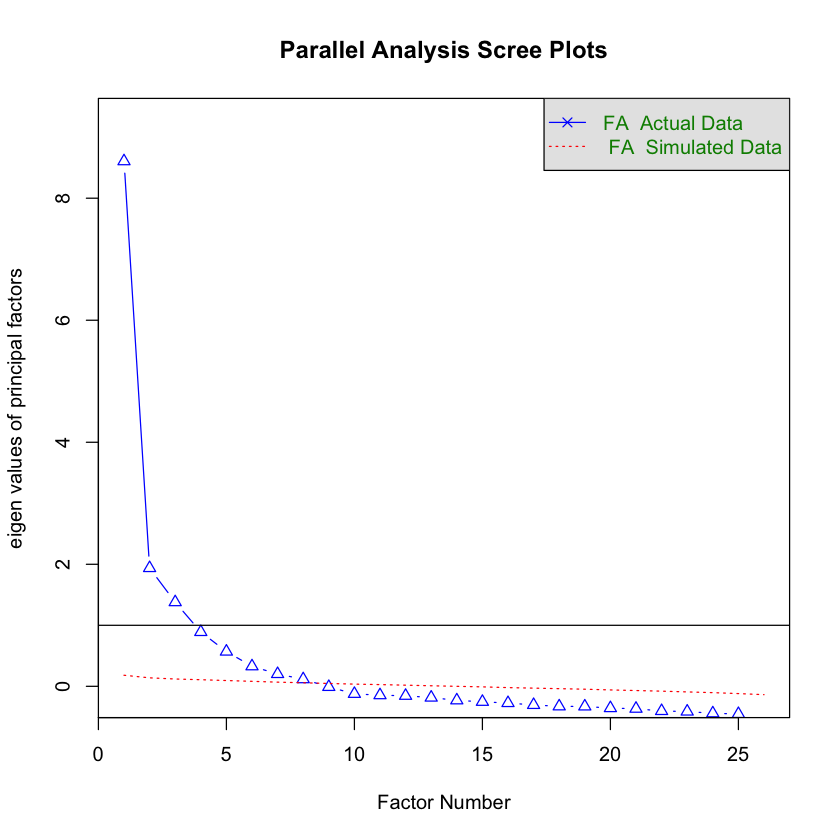

In [19]:
psych::fa.parallel(pcor, n.obs = 3633, fm = "pa", fa = "fa")

The following code chunk performs and prints the factor analysis.
-The factor method is Principal Axis ("pa"). This method is best for non-normally distributed data.
-The rotation is "oblimin", a standard oblique rotation, meaning that the it allows the extracted factors to be correlated with each other. I chose "oblimin" because factors in this dataset are all related to a common construct and are likely to be correlated. The purpose of rotations is to "obtain simple structure in order to enhance interpretability of the solution" (Norris). 

In [20]:
fac <- psych::fa(pcor, nfactors=8, fm="pa", n.obs=3633, rotate="oblimin")
print(fac)

Factor Analysis using method =  pa
Call: psych::fa(r = pcor, nfactors = 8, n.obs = 3633, rotate = "oblimin", 
    fm = "pa")
Standardized loadings (pattern matrix) based upon correlation matrix
      PA4   PA2   PA3   PA1   PA5   PA6   PA8   PA7   h2   u2 com
Q1   0.00  0.91 -0.02  0.05  0.04  0.00  0.01  0.00 0.78 0.22 1.0
Q2   0.04  0.09  0.06  0.07  0.07 -0.67  0.07  0.13 0.57 0.43 1.2
Q3  -0.03  0.00 -0.04  0.85 -0.02  0.00 -0.03  0.01 0.76 0.24 1.0
Q4  -0.75  0.03 -0.02  0.13  0.03  0.00  0.07  0.08 0.63 0.37 1.1
Q5  -0.07  0.00 -0.22  0.05  0.12  0.33 -0.09  0.21 0.46 0.54 3.2
Q6   0.05 -0.02  0.06  0.13 -0.77  0.02  0.03  0.11 0.60 0.40 1.1
Q7  -0.03  0.04 -0.03  0.15  0.14 -0.04 -0.31  0.22 0.26 0.74 2.9
Q8  -0.87 -0.02  0.06  0.02  0.06  0.04  0.04  0.06 0.78 0.22 1.0
Q9  -0.03  0.01  0.02 -0.01  0.83  0.04 -0.03  0.03 0.74 0.26 1.0
Q10  0.00  0.01  0.78  0.01 -0.03 -0.02 -0.03  0.01 0.62 0.38 1.0
Q11 -0.04  0.01  0.02  0.87  0.00  0.03 -0.03 -0.02 0.82 0.18 1.0
Q12 -0.01  0.1

The above model is a good fit: root mean square of residuals is 0.01, the Tucker Lewis index is 0.95, and RMSEA index is < 0.05

### Interpreting the factor analysis

Next I explored which questions ended up in which factor.

The following code saves the loadings to a dataFrame and renames the columns. 

In [41]:
fa_loadings <- fac$loadings%>%
  as.table()%>%
  as.data.frame()%>%
  filter(Freq>=0.3 | Freq<=-0.3)
colnames(fa_loadings)<-c("Question", "Factor", "Loading")
levels(fa_loadings$Factor)<-c("PA1","PA2","PA3","PA4","PA5","PA6","PA7","PA8")

This sets up a list that allows you to find the text of each question using questions$Q#

In [43]:
#set up empty list:
questions<-vector(mode = "list", length =26)

#set up an empty list of names:
qnames<-vector(mode = "character", length = 26)

#read in the the part of the codebook that lists the questions to a temporary file
temp<-readLines("NIS_data/codebook.txt")[9:34]

#the first item of each line in temp is the question # and the 2nd item is the question text:
for (i in 1:26){
  qnames[i]<-strsplit(temp[i], '\t')[[1]][1]
  questions[i]<-strsplit(temp[i], '\t')[[1]][2]
  names(questions)<-qnames
}
questions

$Q1
[1] "I use my hands and arms to gesture while talking to people. "

$Q2
[1] "I touch others on the shoulder or arm while talking to them. "

$Q3
[1] "I use a monotone or dull voice while talking to people. "

$Q4
[1] "I look over or away from others while talking to them. "

$Q5
[1] "I move away from others when they touch me while we are talking. "

$Q6
[1] "I have a relaxed body position when I talk to people. "

$Q7
[1] "I frown while talking to people. "

$Q8
[1] "I avoid eye contact while talking to people. "

$Q9
[1] "I have a tense body position while talking to people. "

$Q10
[1] "I sit close or stand close to people while talking with them. "

$Q11
[1] "My voice is monotonous or dull when I talk to people. "

$Q12
[1] "I use a variety of vocal expressions when I talk to people. "

$Q13
[1] "I gesture when I talk to people. "

$Q14
[1] "I am animated when I talk to people. "

$Q15
[1] "I have a bland facial expression when I talk to people. "

$Q16
[1] "I move closer to people when I talk to them. "

$Q17
[1] "I look directly at people while talking to them. "

$Q18
[1] "I am stiff when I talk to people. "

$Q19
[1] "I have a lot of vocal variety when I talk to people. "

$Q20
[1] "I avoid gesturing while I am talking to people. "

$Q21
[1] "I lean toward people when I talk to them. "

$Q22
[1] "I maintain eye contact with people when I talk to them. "

$Q23
[1] "I try not to sit or stand close to people when I talk with them. "

$Q24
[1] "I lean away from people when I talk to them. "

$Q25
[1] "I smile when I talk to people. "

$Q26
[1] "I avoid touching people when I talk to them."

In [ ]:
This adds a column to the fa_loadings DataFrame that is the text of each question.

In [42]:
fa_loadings$Question_txt<-factor(NA,levels = c("I use my hands and arms to gesture while talking to people. ","I touch others on the shoulder or arm while talking to them. ","I use a monotone or dull voice while talking to people. ","I look over or away from others while talking to them. ","I move away from others when they touch me while we are talking. ","I have a relaxed body position when I talk to people. ", "I frown while talking to people. ","I avoid eye contact while talking to people. ", "I have a tense body position while talking to people. ","I sit close or stand close to people while talking with them. ","My voice is monotonous or dull when I talk to people. ","I use a variety of vocal expressions when I talk to people. ", "I gesture when I talk to people. ","I am animated when I talk to people. ","I have a bland facial expression when I talk to people. ","I move closer to people when I talk to them. ","I look directly at people while talking to them. ","I am stiff when I talk to people. ","I have a lot of vocal variety when I talk to people. ","I avoid gesturing while I am talking to people. ","I lean toward people when I talk to them. ","I maintain eye contact with people when I talk to them. ","I try not to sit or stand close to people when I talk with them. ","I lean away from people when I talk to them. ","I smile when I talk to people. ","I avoid touching people when I talk to them."))

for (i in unique(fa_loadings$Question)){
  fa_loadings$Question_txt[fa_loadings$Question==i]<-as.character(questions[i])
}
fa_loadings<-arrange(fa_loadings, Factor)
fa_loadings

Question,Factor,Loading,Question_txt
Q4,PA1,-0.7489260,I look over or away from others while talking to them.
Q8,PA1,-0.8678804,I avoid eye contact while talking to people.
Q17,PA1,0.8647455,I look directly at people while talking to them.
Q22,PA1,0.8986929,I maintain eye contact with people when I talk to them.
Q1,PA2,0.9084591,I use my hands and arms to gesture while talking to people.
Q13,PA2,0.9226433,I gesture when I talk to people.
Q14,PA2,0.3823173,I am animated when I talk to people.
Q20,PA2,-0.6565457,I avoid gesturing while I am talking to people.
Q10,PA3,0.7752308,I sit close or stand close to people while talking with them.
Q16,PA3,0.8143854,I move closer to people when I talk to them.
